Test Function


First cell: I defined the parameters like the dimensions of field, the number of stars and exponent of the potential laws and the IMF function

In [1]:
# FIRST CELL
import numpy as np
import matplotlib.pyplot as plt
import random as rnd
import cython as cpy

'''
Funzioni che devo implementare:
	- generazione	IMF  = (m/m0)^-alpha	alpha = 2
	  distrubuzione	m/m0 = IMF^(-1/alpha)
	  m in [0.1,20]
	- luminosità	L/L0 = (m/m0)^beta	beta  = 3
	- 

'''
# dimension of the matrix
N = int(1e2)
# number of stars
M = int(50)

# Set parameters
alpha = 2
beta  = 3
m_min = 0.1; m_max = 20

IMF = lambda m : m**(-alpha)
IMF_min = IMF(0.1); IMF_max = IMF(20) 




Second and Third cells: I defined the function for the random generation of the masses and I created the luminosity array

0.1005630195281341 0.6169039032333162


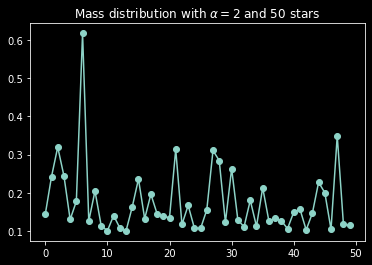

In [2]:
# SECOND CELL
##* Genration of masses array with IMF distribution
#	param	min	minimum imf value
# 	param	max	maximum	imf value
# 
# 	return	m	M array of masses distributed like imf   
def generate_mass_array(min,max):
	np.random.seed()
	imf = np.random.rand(M)*(max-min)+min
	return imf**(-1/alpha)

# masses
m = generate_mass_array(IMF_min,IMF_max)


# Plot data
print(min(m), max(m))

plt.title(f'Mass distribution with $\\alpha = {alpha}$ and {M} stars')
plt.plot(m,'o-')

plt.show()



0.0010000000000000002 8000
0.001016985861612858 0.23477538114629978


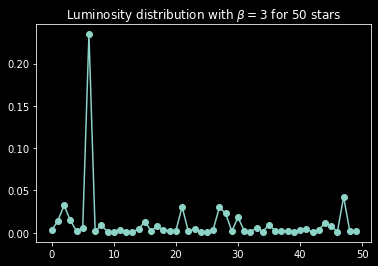

In [3]:
# THIRD CELL
# luminosuities
L = m**beta

# Plot data
print(0.1**beta,20**beta)
print(min(L), max(L))
plt.title(f'Luminosity distribution with $\\beta = {beta}$ for {M} stars')
plt.plot(L,'o-')

plt.show()

Fourth cell: I defined the star class obj, a class that contains all infos about star (mass,lum and position), the function to set stars positions and the function to update the field matrix with the stars luminosities in mag

In [4]:
# FOURTH CELL
##* Star class obj
class star(object):
#		param	mass	star mass
#		param	lum	star luminosity
# 		param	x,y 	star coordinates in the field 	
	def __init__(self,mass, lum, x ,y):
		self.m   = mass		# star mass value
		self.lum = lum		# star luminosity value
		self.x = x		# star x coordinate
		self.y = y		# star y coordinate

##* Function to locate the stars
#   It generates 2 arrays with the x and y position of each star
#?  Da rigurdare bene
#	param	n	number of stars
#
#	return	X,Y	stars coordinate arrays
def star_location(n):
	tmp = np.random.default_rng()
	X = tmp.choice(N, size=n)
	Y = tmp.choice(N, size=n, replace=False)
	return X, Y	

##* Transfer function
#   Converts luminosities in a scale from 0 to 1 for the function
#   plt.imshow()
# 	param	l	luminosity array
# 
# 	return	val	converted magnitudes array   
def transfer_function(l):
	inf = 9e-4; sup = 8000;
	return(np.log10(l)-np.log10(inf))/(np.log10(sup)-np.log10(inf))

##* Function to update field with the stars
#	param	F	field matrix
#	param	X,Y	coordinate arrays
#	param	l	luminosity array
# 
# 	return	F	updated field matrix 
def exposure(F,X,Y,l):
	for i in range(3):
		F[X,Y,i] = transfer_function(l)
	# for i in range(dim):
	# 	F[X[i],Y[i],:] = transfer_function(val[i])
	return F



Fifth cell: I defined the inizialize function to set stars in field and the fov function to select a portion of the field

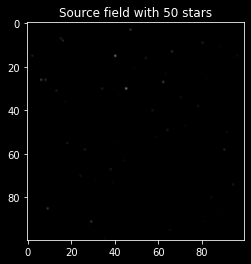

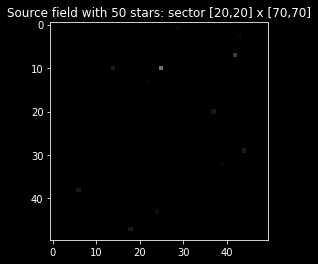

In [6]:
# FIFTH CELL

def initialize():
	F = np.zeros([N,N,3])
	m = generate_mass_array(IMF_min,IMF_max)
	L = m**beta
	xs,ys = star_location(M)
	F = exposure(F,xs,ys,L)
	S = star(m,L,xs,ys)
	return F, S

def fov(F,inf=[0,0],sup=[int(N/3),int(N/3)]):
	if((inf[0]<0) or (inf[1]<0) or (sup[0]>=N) or (sup[1]>=N)):
		print('Error')
		return F
	return F[inf[0]:sup[0],inf[1]:sup[1],:] 

F, S = initialize()
Ls = S.lum
inf = [20,20]
sup = [70,70]
field = fov(F,inf,sup)

plt.figure(1)
plt.title(f'Source field with {M} stars')
plt.imshow(F)
plt.figure(2)
plt.title(f'Source field with {M} stars: sector [{inf[0]},{inf[1]}] x [{sup[0]},{sup[1]}]')
plt.imshow(field)
plt.show()

Sixth cell: 

In [33]:
# SIXTH CELL
def gaussian(r,sigma=2):
	return np.exp(r**2/sigma**2/2)

def lorentzian(r,rs,a=4):
	return 1/( (r-rs)**2 + a**2 )

def atm_seeing(s_psf='g'):
	

IndentationError: expected an indented block (3871236329.py, line 8)